<a id='preface'></a>
## <font color='darkblue'>Preface</font>
[Issue2](https://github.com/johnklee/ff_crawler/issues/2) aims to collect post/articles from below websites for future analsysis:
* https://www.androidcentral.com/ ([Category Rank 109](https://www.similarweb.com/website/androidcentral.com/))
* https://www.androidpolice.com/ ([Category Rank 198](https://www.similarweb.com/website/androidpolice.com/))
* https://www.xda-developers.com/ ([Category Rank 107](https://www.similarweb.com/website/xda-developers.com/))

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'>[**Experiment - Crawling HTML page**](#crawl_exp)</font>
* <font size='3ptx'>[**Design - ExplorerWorker**](#design_explorerstar)</font>
* <font size='3ptx'>[**Analysis Of Collected Interested Post**](#analysis_of_post)</font>

In [39]:
import requests as reqlib
import os
import re
import random
import time
import pickle
import abc
import hashlib
import threading
import matplotlib
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from shutil import copyfile
from purifier import TEAgent
from purifier.logb import getLogger
from enum import IntEnum
from typing import Tuple, List, Dict, Optional

<a id='crawl_exp'></a>
## <font color='darkblue'>Experiment - Crawling HTML page</font>
Here we will define a few classes with crawling functionality for later usage:
* <font size='3ptx'>[**AndroidCentral**](#androidcentral)</font>
* <font size='3ptx'>[**AndroidPolicy**](#androidpolicy)</font>
* <font size='3ptx'>[**XDA-Developer**](#xda-developer)</font>

In [44]:
##########################################
# utils.py
##########################################

class ScraperNot200(Exception):
    def __init__(self, sc):
        self.sc = sc
        
    def __str__(self):
        return f"Unexpected Status Code={self.sc}!"

class UnsupportedMIME(Exception):
    def __init__(self, mime):
        self.mime = mime
        
    def __str__(self):
        return f"Unsupported MIME={self.mime}!"
    

class Scraper(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def get(self, url):
        pass

class ReqScraper(object):
    def __init__(self, 
                 page_cache_path="page_caches",
                 headers={'User-Agent': 'Mozilla/5.0'},
                 skip_cache=False,
                 supported_mime_set={"text/html"}):
        self.page_cache_path = page_cache_path        
        if not os.path.isdir(self.page_cache_path):
            os.makedirs(self.page_cache_path)
            
        self.headers = headers            
        self.logger = getLogger(os.path.basename(self.__class__.__name__))
        self.skip_cache = skip_cache
        self.supported_mime_set = supported_mime_set
    
    def _get_cache_path(self, url):
        test_url_host = urlparse(url).netloc
        url_md5 = hashlib.md5(url.encode('utf-8')).hexdigest()
        cache_file_name = f"{test_url_host}_{url_md5}.txt"
        cache_file_path = os.path.join(self.page_cache_path, cache_file_name)
        return cache_file_path
    
    def _get_from_cache(self, url):
        cache_file_path = self._get_cache_path(url)        
        if os.path.isfile(cache_file_path):
            self.logger.debug(f"Return content of {url} from cache...")
            with open(cache_file_path, 'r', encoding='utf8') as fo:
                return fo.read()
            
        return None
    
    def _save2cache(self, url, html_content):
        cache_file_path = self._get_cache_path(url)
        with open(cache_file_path, 'w', encoding='utf8') as fw:
            fw.write(html_content)
    
    def get(self, url):
        if not self.skip_cache:
            cache_text = self._get_from_cache(url)
            if cache_text is not None:
                return cache_text
            
        self.logger.debug(f"Crawling {url}...")
        resp = reqlib.get(url, headers=self.headers)
        if resp.ok:
            mime = resp.headers['content-type'].split(';')[0].strip()
            self.logger.debug(f"URL={url} with MIME={mime}...")
            if mime.lower() not in self.supported_mime_set:
                raise UnsupportedMIME(mime)
                
            self._save2cache(url, resp.text)
            return resp.text
        else:
            raise ScraperNot200(resp.status_code)

In [3]:
# sr_agent = ReqScraper(skip_cache=False)
sr_agent = ReqScraper()

In [4]:
androidcentral_host_url = 'https://www.androidcentral.com/'
androidcentral_host_html = sr_agent.get(androidcentral_host_url)

MainThread/INFO: <<ipython-input-2-b7bd96941ad2>#50> Return content of https://www.androidcentral.com/ from cache...


In [5]:
androidcentral_host_html[:100]

'<!DOCTYPE html>\n<html dir="ltr">\n<head>\n<meta charset="UTF-8" />\n<meta name="viewport" content="widt'

In [6]:
extractor = TEAgent(
    policy_path="policy", 
    disable_policy=True,
    ext_title=True
)
print(str(extractor.handlers['text/html'].stg_dict) + "\n\n")
is_succ, rst, handler = extractor.parse(
    "text/html", 
    androidcentral_host_url, 
    androidcentral_host_html,
    do_ext_link=True
)
print(f"is_succ: {is_succ} (title={rst['title']}):\n{rst['text']}\n")

{'r:https?://www\\.androidcentral\\.com/[^/]+$': purifier.policy.policy1001 (policy_androidcentral_1/None:r:https?://www\.androidcentral\.com/[^/]+$), 'r:https?://www\\.androidpolice\\.com/\\d{4}/\\d{1,2}/\\d{1,2}/[^/]+/?$': purifier.policy.policy1001 (policy_androidpolicy_1/None:r:https?://www\.androidpolice\.com/\d{4}/\d{1,2}/\d{1,2}/[^/]+/?$), 'r:https?://www\\.xda-developers\\.com/[^/]+/?$': purifier.policy.policy1001 (policy_xdadep_1/None:r:https?://www\.xda-developers\.com/[^/]+/?$)}


is_succ: True (title=Android Central - News, Reviews, Deals & Help on all Android devices):
Android Central - News, Reviews, Deals & Help on all Android devices
Battle of the super streamers

Michael L Hicks  11 hours ago

Several new streaming devices have launched or are launching within a month of one another, cramming in new specs and features while driving down prices to compete with one another. We're weighing the best dongles, sticks and devices from Amazon, Google, Apple, Roku, Nvidia and o

In [7]:
rst['all_links']

['http://www.youtube.com/subscription_center?utm_source=ac&utm_medium=burger&utm_campaign=navigation&add_user=AndroidCentral',
 'https://www.androidcentral.com/best-wifi-6-routers',
 'https://www.androidcentral.com/playstation-now-could-be-serious-xcloud-competitor-android',
 'https://www.futureplc.com/services/advertising',
 'https://www.thrifter.com/?utm_source=ac&utm_medium=navbar&utm_campaign=navigation',
 'https://www.futureplc.com/services/endorsement-licensing/?utm_source=ac&utm_medium=drawer&utm_campaign=navigation',
 'http://youtube.com/c/themrmobile?utm_source=ac&utm_medium=drawer&utm_campaign=navigation&sub_confirmation=1',
 'https://www.androidcentral.com/best-chromebook',
 'https://www.androidcentral.com/about',
 'https://www.androidcentral.com/ac-podcast-522-android-12-sony-xperia-1iii-fitbit-luxe-apple-event',
 'https://www.androidcentral.com/what-know-about-resident-evil-villages-demo-weekend',
 'https://www.androidcentral.com/latest-whatsapp-beta-brings-playback-speed-

<a id='androidcentral'></a>
### <font color='darkgreen'>AndroidCentral</font> ([back](#crawl_exp))
Let's explore the page of [website](https://www.androidcentral.com/android) and design text extraction policy for it:

In [8]:
# Demo text extraction
# https://github.com/johnklee/scraper-text-purifier/blob/main/README.md
androidcentral_test_url = "https://www.androidcentral.com/latest-whatsapp-beta-brings-playback-speed-control-voice-notes"
androidcentral_test_host = urlparse(androidcentral_test_url).netloc

In [9]:
androidcentral_test_html = sr_agent.get(androidcentral_test_url)

MainThread/INFO: <<ipython-input-2-b7bd96941ad2>#50> Return content of https://www.androidcentral.com/latest-whatsapp-beta-brings-playback-speed-control-voice-notes from cache...


In [10]:
androidcentral_test_html[:100]

'<!DOCTYPE html>\n<html dir="ltr">\n<head>\n<meta charset="UTF-8" />\n<meta name="viewport" content="widt'

In [11]:
extractor = TEAgent(
    policy_path="policy", 
    disable_policy=True,
    ext_title=True
)
print(str(extractor.handlers['text/html'].stg_dict) + "\n\n")
is_succ, rst, handler = extractor.parse(
    "text/html", 
    androidcentral_test_url, 
    androidcentral_test_html,
    do_ext_link=True
)
print(f"is_succ: {is_succ} (title={rst['title']}):\n{rst['text']}\n")

{'r:https?://www\\.androidcentral\\.com/[^/]+$': purifier.policy.policy1001 (policy_androidcentral_1/None:r:https?://www\.androidcentral\.com/[^/]+$), 'r:https?://www\\.androidpolice\\.com/\\d{4}/\\d{1,2}/\\d{1,2}/[^/]+/?$': purifier.policy.policy1001 (policy_androidpolicy_1/None:r:https?://www\.androidpolice\.com/\d{4}/\d{1,2}/\d{1,2}/[^/]+/?$), 'r:https?://www\\.xda-developers\\.com/[^/]+/?$': purifier.policy.policy1001 (policy_xdadep_1/None:r:https?://www\.xda-developers\.com/[^/]+/?$)}


is_succ: True (title=Latest WhatsApp beta brings playback speed control for voice notes | Android Central):
23 Apr 2021

Source: Harish Jonnalagadda / Android Central

What you need to know

* The latest WhatsApp beta for Android adds support for different playback speeds for voice messages.
* When you play a voice message, you will now see a playback speed button.
* You can choose from three playback speeds by tapping on the new button: 1x, 1.5x, and 2x.

What you need to know

* The latest WhatsA

In [12]:
handler

{'reason': ('purifier.policy.policy1001',
  'policy_androidcentral_1',
  'default',
  'r:https?://www\\.androidcentral\\.com/[^/]+$')}

<a id='androidpolicy'></a>
### <font color='darkgreen'>AndroidPolicy</font> ([back](#crawl_exp))
Let's explore the page of [website](https://www.androidpolice.com/) and design text extraction policy for it:

In [13]:
# Demo text extraction
androidpolicy_test_url = "https://www.androidpolice.com/2021/04/23/our-first-potential-pixel-5a-camera-sample-looks-like-it-comes-from-a-very-familiar-sensor/"
androidpolicy_test_url_host = urlparse(androidpolicy_test_url).netloc

In [14]:
androidpolicy_test_html = sr_agent.get(androidpolicy_test_url)

MainThread/INFO: <<ipython-input-2-b7bd96941ad2>#50> Return content of https://www.androidpolice.com/2021/04/23/our-first-potential-pixel-5a-camera-sample-looks-like-it-comes-from-a-very-familiar-sensor/ from cache...


In [15]:
androidpolicy_test_html[:100]

'<!DOCTYPE html>\n<html lang="en-US">\n<head>\n\n<meta http-equiv="Content-Type" content="text/html; char'

In [16]:
extractor = TEAgent(
    policy_path="policy", 
    disable_policy=True,
    ext_title=True
)
print(str(extractor.handlers['text/html'].stg_dict) + "\n\n")
is_succ, rst, handler = extractor.parse(
    "text/html", 
    androidpolicy_test_url, 
    androidpolicy_test_html,
    do_ext_link=True
)
print(f"is_succ: {is_succ} (title={rst['title']}):\n{rst['text']}\n")

{'r:https?://www\\.androidcentral\\.com/[^/]+$': purifier.policy.policy1001 (policy_androidcentral_1/None:r:https?://www\.androidcentral\.com/[^/]+$), 'r:https?://www\\.androidpolice\\.com/\\d{4}/\\d{1,2}/\\d{1,2}/[^/]+/?$': purifier.policy.policy1001 (policy_androidpolicy_1/None:r:https?://www\.androidpolice\.com/\d{4}/\d{1,2}/\d{1,2}/[^/]+/?$), 'r:https?://www\\.xda-developers\\.com/[^/]+/?$': purifier.policy.policy1001 (policy_xdadep_1/None:r:https?://www\.xda-developers\.com/[^/]+/?$)}


is_succ: True (title=Possible Pixel 5a camera sample raises some interesting hardware questions about Google's next phone):
Possible Pixel 5a camera sample raises some interesting hardware questions about Google's next phone
Recycling is a good thing, no?

In demonstrating advances with its HDR image capture technique, Google may have tilted its sleeve a bit too far to reveal what may be a camera sample from the upcoming Pixel 5a.

In fact, it's this very picture — taken across from the Neo 19 shop

In [17]:
handler

{'reason': ('purifier.policy.policy1001',
  'policy_androidpolicy_1',
  'default',
  'r:https?://www\\.androidpolice\\.com/\\d{4}/\\d{1,2}/\\d{1,2}/[^/]+/?$')}

In [18]:
rst.keys()

dict_keys(['te_suc', 'text', 'all_links', 'body_a_links', 'body_txt_links', 'title'])

<a id='xda-developer'></a>
### <font color='darkgreen'>XDA-Developer</font> ([back](#crawl_exp))
Let's explore the page of [website](https://www.xda-developers.com/) and design text extraction policy for it:

In [19]:
# Demo text extraction
xdadep_test_url = "https://www.xda-developers.com/volta-spark-brings-magsafe-style-cables-to-usb-c/"
xdadep_test_url_host = urlparse(xdadep_test_url).netloc

In [20]:
xdadep_test_html = sr_agent.get(xdadep_test_url)

MainThread/INFO: <<ipython-input-2-b7bd96941ad2>#50> Return content of https://www.xda-developers.com/volta-spark-brings-magsafe-style-cables-to-usb-c/ from cache...


In [21]:
xdadep_test_html[:100]

'<!doctype html><html xmlns="http://www.w3.org/1999/xhtml" lang="en-US" style="margin-top:0!important'

In [22]:
extractor = TEAgent(
    policy_path="policy", 
    disable_policy=True,
    ext_title=True
)
print(str(extractor.handlers['text/html'].stg_dict) + "\n\n")
is_succ, rst, handler = extractor.parse(
    "text/html", 
    xdadep_test_url, 
    xdadep_test_html,
    do_ext_link=True
)
print(f"is_succ: {is_succ} (title={rst['title']}):\n{rst['text']}\n")

{'r:https?://www\\.androidcentral\\.com/[^/]+$': purifier.policy.policy1001 (policy_androidcentral_1/None:r:https?://www\.androidcentral\.com/[^/]+$), 'r:https?://www\\.androidpolice\\.com/\\d{4}/\\d{1,2}/\\d{1,2}/[^/]+/?$': purifier.policy.policy1001 (policy_androidpolicy_1/None:r:https?://www\.androidpolice\.com/\d{4}/\d{1,2}/\d{1,2}/[^/]+/?$), 'r:https?://www\\.xda-developers\\.com/[^/]+/?$': purifier.policy.policy1001 (policy_xdadep_1/None:r:https?://www\.xda-developers\.com/[^/]+/?$)}


is_succ: True (title=VOLTA Spark Brings MagSafe-style Cables to USB-C):
VOLTA Spark Brings MagSafe-style Cables to USB-C

When you use a USB-C cable every day, you begin to realize how important it is to have a nice high-quality cable. We all have different types of devices that have different types of charge ports, so keeping track of multiple cables can become a bit of a hassle. VOLTA has created a cable that solves both of these issues while recreating the convenience of the MagSafe charger desi

<a id='design_explorerstar'></a>
## <font color='darkblue'>Design - ExplorerWorker</font>
We define a class <font color='blue'>**ExplorerWorker**</font> to help us to crawl a specific site.

In [53]:
##########################################
# utils.py
##########################################
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
class ThreadState(IntEnum):
    STOPPED = 0
    RUNNING = 1
    STOPPING = 2
    
    
class CrawlAgent(object):
    def __init__(self, name, throttling_range=(1, 3)):
        self.rs = ReqScraper(page_cache_path=f"{name}_cache")
        self.et = TEAgent(
            policy_path="policy", 
            disable_policy=True,
            ext_title=True
        )
        self.logger = getLogger(os.path.basename(self.__class__.__name__))
        self.throttling_range = throttling_range
        
    def handle(self, url:str) -> Tuple[str, str, List[str]]:
        try:
            wait_in_sec = random.uniform(*self.throttling_range)
            self.logger.debug(f"throttling wait {wait_in_sec}s...")
            time.sleep(wait_in_sec)
            url_content_html = self.rs.get(url)
            is_succ, rst, handler = self.et.parse(
                "text/html", 
                url, 
                url_content_html,
                do_ext_link=True
            )
            if is_succ:
                return (rst['title'], rst['text'], rst['all_links'])
            else:
                return (rst['title'], rst['text'], rst['all_links'])
        except ScraperNot200 as e:
            self.logger.warning(f"Fail to handle URL={url}: {str(e)}")
            return None, None, None
        except UnsupportedMIME as e:
            self.logger.warning(f"Fail to handle URL={url}: {str(e)}")
            return None, None, None

        
class ExplorerWorker(threading.Thread):
    def __init__(
        self, 
        name:str, 
        url_ptn:str, 
        src_url:str, 
        test_run:int=-1,
        page_saved_dir:Optional[str]=None):
        super(ExplorerWorker,  self ).__init__(name = name)
        self.name = name
        self.url_ptn = url_ptn
        self.src_url = src_url
        self.test_run = test_run
        self.ca = CrawlAgent(name)
        self.pc_dict = self._get_pc_dict()
        ''' Processed result cache: Key as URL; value as bool (True means this URL is crawled successfully)'''
        self.state = ThreadState.STOPPED
        ''' Thread state: 0-> stopped; 1-> running; 2-> stopping'''
        self.logger = getLogger(os.path.basename(self.__class__.__name__))
        ''' Logger object '''
        self.page_saved_dir = page_saved_dir if page_saved_dir is not None else f"{self.name}_pages_output"
        ''' Path or directory to save dump page'''
        
        if not os.path.isdir(self.page_saved_dir):
            os.makedirs(self.page_saved_dir)
        
    def _get_output_page_path(self, url):
        url_host = urlparse(url).netloc
        url_md5 = hashlib.md5(url.encode('utf-8')).hexdigest()
        page_file_name = f"{url_host}_{url_md5}.txt"
        page_file_path = os.path.join(self.page_saved_dir, page_file_name)
        return page_file_path
    
    def _get_pc_serialized_file(self) -> str:
        return f"{self.name}_pc_dict.pkl"
    
    def _get_pc_dict(self) -> Dict[str, bool]:
        pkl_file = self._get_pc_serialized_file()
        if os.path.isfile(pkl_file):
            with open(pkl_file, 'rb') as fo:
                return pickle.load(fo)
        else:
            return {}
    
    def _serialized(self):
        pkl_file = self._get_pc_serialized_file()
        with open(pkl_file, 'wb') as fo:
            pickle.dump(self.pc_dict, fo)
            
    def run(self):
        self.state = ThreadState.RUNNING
        url_queue = [self.src_url]
        pc = sc = fc = oc = 0
        while self.state == ThreadState.RUNNING and url_queue:
            url = url_queue.pop(0)
            pc += 1
            if url not in self.pc_dict:
                # New URL
                self.logger.debug(f"Handling URL={url}...")
                title, content, collected_urls = self.ca.handle(url)
                if content is None:
                    self.pc_dict[url] = False
                    fc += 1
                else:
                    if url != self.src_url:
                        self.pc_dict[url] = True
                        
                    sc += 1                    
                    next_level_urls = list(filter(lambda u: re.match(self.url_ptn, u) is not None, collected_urls))
                    if next_level_urls:
                        self.logger.debug(f"Collected {len(next_level_urls)} next level URL(s)")
                        url_queue.extend(next_level_urls)
                    
                    if content:                        
                        page_output_path = self._get_output_page_path(url)
                        with open(page_output_path, 'w', encoding='utf8') as fw:
                            fw.write(f"{url}\n\n")
                            fw.write(f"{title}\n\n")
                            fw.write(f"{content}")
                            self.logger.debug(f"Saved page to {page_output_path}!")
                            
                    self.logger.info(f"Completed URL={url} ({len(url_queue):,d})")
            else:
                # Old URL
                self.logger.info(f"URL={url} is already handled...")
                oc += 1
                continue
                
            if self.test_run > 0:
                if (sc + fc) > self.test_run:
                    self.logger.info(f"Exceed test_run={self.test_run} and therefore stop running...")
                    break
                    
            if pc % 2 == 0:
                self.logger.info(bcolors.OKBLUE + bcolors.BOLD + f"{pc} URL completed: sc={sc:,d}; fc={fc:,d}; oc={oc:,d}\n" + bcolors.ENDC)
        
        self.logger.warning(f"Explorer is stopped! (name={self.name})...")
        self.state = ThreadState.STOPPED
    
    def stop(self):
        self.logger.warning(f"Stopping explorer worker (name={self.name})...")
        if self.state == ThreadState.RUNNING:
            self.state = ThreadState.STOPPING
            while self.state != ThreadState.STOPPED:
                time.sleep(1)
            
        self.logger.warning(f"Serialized explorer result (name={self.name})...")
        self._serialized()

In [54]:
# Prior run for testing
ew = ExplorerWorker(
    name="androidcentral",
    src_url="https://www.androidcentral.com/",
    url_ptn=r'https?://www\.androidcentral\.com/[^/]+$',
    test_run=5
)
ew.start()
ew.join()
ew.stop()
print("Done!")

androidcentral/INFO: <<ipython-input-53-ca012e1fba7e>#137> Completed URL=https://www.androidcentral.com/ (83)
androidcentral/INFO: <<ipython-input-53-ca012e1fba7e>#140> URL=https://www.androidcentral.com/best-wifi-6-routers is already handled...
androidcentral/INFO: <<ipython-input-53-ca012e1fba7e>#140> URL=https://www.androidcentral.com/playstation-now-could-be-serious-xcloud-competitor-android is already handled...
androidcentral/INFO: <<ipython-input-53-ca012e1fba7e>#140> URL=https://www.androidcentral.com/best-chromebook is already handled...
androidcentral/INFO: <<ipython-input-53-ca012e1fba7e>#140> URL=https://www.androidcentral.com/about is already handled...
androidcentral/INFO: <<ipython-input-53-ca012e1fba7e>#140> URL=https://www.androidcentral.com/ac-podcast-522-android-12-sony-xperia-1iii-fitbit-luxe-apple-event is already handled...
androidcentral/INFO: <<ipython-input-53-ca012e1fba7e>#140> URL=https://www.androidcentral.com/what-know-about-resident-evil-villages-demo-week

Done!


<a id='analysis_of_post'></a>
## <font color='darkblue'>Analysis Of Collected Interested Post</font> ([back](#preface))
Let's cluster our collected interested post and check a few post from each cluster:

In [13]:
import os
import gensim.downloader as api
import pandas as pd
import numpy as np
import nltk
from typing import Tuple
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans, KMeans

In [2]:
wv = api.load('word2vec-google-news-300')

In [4]:
#nltk.download('punkt')

In [8]:
CLUSTER_SIZE = 10
POST_DIR_PATH = 'interested_pages'
RANDOM_STATE = 1
KM_BATCH_SIZE = 6
KM_MAX_ITER = 20

In [4]:
columns = ['file', 'title'] + [f"v{i}" for i in range(300)]

In [6]:
%%time
def read_post(fp:str) -> Tuple[str,str]:
    with open(fp, 'r', encoding='utf8') as fo:
        url = fo.readline().strip()
        fo.readline()
        title = fo.readline().strip()
        fo.readline()
        body = fo.read().strip()
        return (title, body)
        
files = list(map(lambda f: os.path.join(POST_DIR_PATH, f), os.listdir(POST_DIR_PATH)))
rows = []
with tqdm(total=len(files)) as pbar:
    for fp in files:
        title, body = read_post(fp)
        doc_vec = np.zeros(300)
        for sent in nltk.sent_tokenize(body):
            for w in nltk.tokenize.word_tokenize(sent):
                try:
                    doc_vec += wv[w]
                except:
                    pass
            
        row = [fp, title]
        row.extend(doc_vec.copy())
        rows.append(row)
        pbar.update(1)
        
docs_df = pd.DataFrame(rows, columns=columns)
docs_df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3396/3396 [02:55<00:00, 19.38it/s]


Wall time: 2min 55s


,file,title,v0,v1,v2,v3,v4,v5,v6,v7,...,v290,v291,v292,v293,v294,v295,v296,v297,v298,v299
0,interested_pages\www.androidcentral.com_004a00...,Best Alexa Devices 2021 | Android Central,196.809924,84.764323,-98.016064,411.054358,-326.324621,137.073229,38.470474,-266.260321,...,-249.393393,146.478892,-628.835919,172.422329,71.678425,-259.013043,12.094636,-226.942574,-20.017273,67.541092
1,interested_pages\www.androidcentral.com_00bd04...,Oculus Quest 2 review: The best VR experience ...,331.377748,161.908948,51.130238,584.188189,-564.070935,68.199461,317.253432,-514.445718,...,-525.553269,370.061274,-567.189018,312.007333,-43.641371,-32.053624,186.398327,-230.037789,78.342421,-241.482962
2,interested_pages\www.androidcentral.com_016f12...,OnePlus 8 review: Better value than ever befor...,58.907837,76.483049,38.356060,193.869913,-157.426455,14.403913,106.682579,-199.488100,...,-188.811573,107.189707,-223.005795,89.829720,-66.722816,-24.416162,31.691511,-92.193150,35.444678,-70.036911
3,interested_pages\www.androidcentral.com_018c3b...,Stadia: Everything you need to know about Goog...,134.574736,-11.661549,119.723120,254.390388,-240.258924,21.142117,171.519716,-157.180869,...,-179.722805,118.029990,-300.935690,74.553823,98.142033,-64.714411,26.975586,-202.769642,-36.570605,-106.021896
4,interested_pages\www.androidcentral.com_027d6e...,ASUS ROG Phone 5 review: The ultimate gaming p...,72.549145,88.657830,89.159472,283.995155,-268.227963,42.667105,217.192316,-326.776190,...,-256.327538,124.973535,-356.071723,156.967677,11.102327,-117.260114,-53.173154,-181.836496,18.720127,-92.780437


In [14]:
%%time
kmeans = KMeans(
    n_clusters=CLUSTER_SIZE,
    random_state=RANDOM_STATE,    
).fit(docs_df.iloc[:, 2:])

Wall time: 476 ms


Let's random select 5 docs from each group:

In [35]:
from collections import defaultdict
g2d_dict = defaultdict(list) # Key as group/cluster; value as list of corresponding doc
for g, t in zip(kmeans.labels_, docs_df.iterrows()):
    g2d_dict[g].append(t[1].file)

In [42]:
for g, docs in g2d_dict.items():
    print(f"Cluster-{g}:")
    for d in random.sample(docs, 5):
        print(f"\t{d}")
        copyfile(d, os.path.join("gdocs", f"{g}_" + os.path.basename(d)))

Cluster-2:
	interested_pages\www.androidcentral.com_2f1f72a4edb641c533714f0901db66e4.txt
	interested_pages\www.xda-developers.com_65860bf6de225d93e0a679deaaf965de.txt
	interested_pages\www.xda-developers.com_4fa49b46a2ebf54577667fc1cb8e41fd.txt
	interested_pages\www.androidpolice.com_086f3db6ddb997511da8a23ef23d71d6.txt
	interested_pages\www.androidcentral.com_e9b560ee25f94900d193b866ad87fbd8.txt
Cluster-7:
	interested_pages\www.androidcentral.com_1d9cb03a3baaa4fec3c4099078ba7b73.txt
	interested_pages\www.xda-developers.com_dd9748866e4d9664f1be1bafe7ebad25.txt
	interested_pages\www.androidcentral.com_bb8c2fb9f6218fd1f9d3d61d4bfc8b9e.txt
	interested_pages\www.xda-developers.com_f547f1eb2de8134888ef103fd315036a.txt
	interested_pages\www.androidcentral.com_ea0ffb6d5fa1aadf692477a5044113e6.txt
Cluster-0:
	interested_pages\www.androidpolice.com_fecae46281cd904b4e5de6a11d77dd24.txt
	interested_pages\www.androidcentral.com_431526e92ce10f06b9253e62a4e050e3.txt
	interested_pages\www.androidpoli

In order to draw the instance on a 2 dimensions of plane, we will use [**PCA**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the feature size:

In [18]:
from sklearn.decomposition import PCA

feature_space = PCA(n_components=2).fit_transform(docs_df.iloc[:, 2:])

In [21]:
feature_space[:10]

array([[ 2162.66315297,   964.6266061 ],
       [ 3779.07125652,  -249.0108755 ],
       [ -586.47122152,  -109.22624342],
       [  555.39689678,   -39.79760273],
       [ 1239.97549561,   414.71690532],
       [ 2162.66315297,   964.6266061 ],
       [-1677.56250016,  -307.51597453],
       [  458.01503769,  -104.33493735],
       [ 2305.35688143,   676.49304865],
       [ 1965.2595979 ,   289.27940336]])

Now let's draw the instance onto the plane:

In [26]:
kmeans.labels_.shape

(3396,)

In [27]:
feature_space.shape

(3396, 2)

100%|█████████████████████████████████████████████████████████████████████████████| 3396/3396 [00:15<00:00, 225.40it/s]


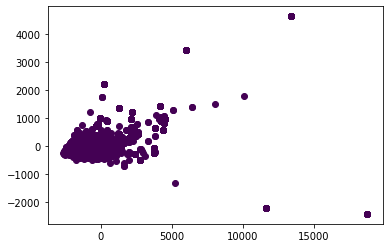

In [31]:
with tqdm(total=len(kmeans.labels_)) as pbar:
    for c, d in zip(kmeans.labels_, feature_space):
        plt.scatter(d[0], d[1], c=c)
        pbar.update(1)
        
plt.show()